✅ Loaded MNIST locally!
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Preprocessed dataset ready for VGG16!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 88s 103ms/step - accuracy: 0.7528 - loss: 0.7794 - val_accuracy: 0.9525 - val_loss: 0.1621
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 100ms/step - accuracy: 0.9311 - loss: 0.2184 - val_accuracy: 0.9603 - val_loss: 0.1263
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 86s 101ms/step - accuracy: 0.9468 - loss: 0.1704 - val_accuracy: 0.9625 - val_loss: 0.1098
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 86s 102ms/step - accuracy: 0.9551 - loss: 0.1387 - val_accuracy: 0.9652 - val_loss: 0.1009
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - accuracy: 0.9580 - loss: 0.1363 - val_accuracy: 0.9695 - val_loss: 0.0870
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 303s 358ms/step - accuracy: 0.9681 - loss: 0.0982 - val_accuracy: 0.9857 - val_loss: 0.0408
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 340s 403ms/step - accuracy: 0.9825 - loss: 0.0519 - val_accuracy: 0.9892 - val_loss: 0.0325
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 332s 394ms/step - accuracy: 0.9899 - loss: 0.0326 

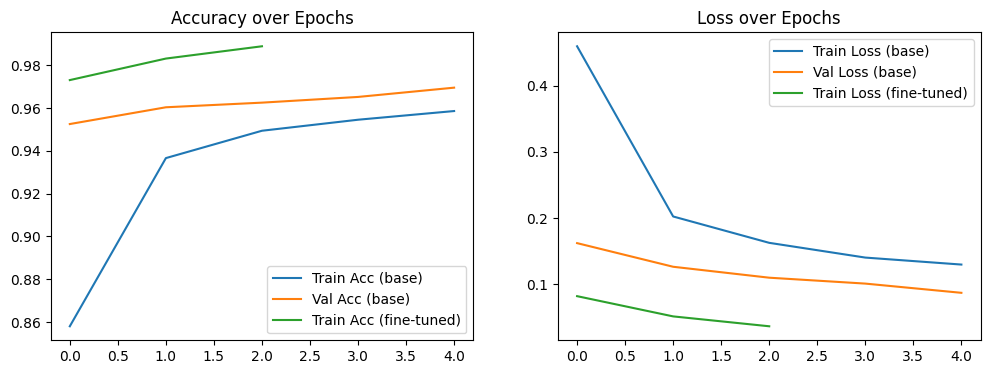

In [ ]:
# --- Stage 0: Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- Stage (a): Load and preprocess local dataset ---
import numpy as np
with np.load(r"C:\Users\kusha\Desktop\mnist_dataset.npz") as data:
    x_train = data["X_train"]
    y_train = data["y_train"]
    x_test  = data["X_test"]
    y_test  = data["y_test"]

print("✅ Loaded MNIST locally!")
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


# Convert to 3-channel RGB (VGG16 expects 3 channels)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test  = np.stack((x_test,) * 3, axis=-1)

# Resize MNIST 28x28 -> 32x32 (VGG16 input)
x_train = tf.image.resize(x_train, [32, 32])
x_test  = tf.image.resize(x_test, [32, 32])
x_train = x_train.numpy()
x_test = x_test.numpy()

# Normalize and one-hot encode labels
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

print("Preprocessed dataset ready for VGG16!")

# --- Stage (b): Load pre-trained CNN (VGG16) and freeze base layers ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze convolutional layers

# --- Stage (c): Add custom classifier on top ---
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')  # MNIST has 10 classes
])

# --- Stage (d): Compile and train classifier layers ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# --- Stage (e): Fine-tune model (unfreeze last convolution block) ---
for layer in base_model.layers[-4:]:
    layer.trainable = True  # Unfreeze last few conv layers

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# --- Evaluation ---
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"✅ Test Accuracy after fine-tuning: {test_acc:.4f}")

# --- Plot results ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc (base)")
plt.plot(history.history["val_accuracy"], label="Val Acc (base)")
plt.plot(fine_tune_history.history["accuracy"], label="Train Acc (fine-tuned)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss (base)")
plt.plot(history.history["val_loss"], label="Val Loss (base)")
plt.plot(fine_tune_history.history["loss"], label="Train Loss (fine-tuned)")
plt.title("Loss over Epochs")
plt.legend()
plt.show()
